# Goals of this page :
    # Baseline : A Deep Learning-based Cryptocurrency Price Prediction Scheme for Financial Institutions
    # In keras redesign the model with ( 30 mins / 1 hr ) data points and compare the results we get.
    # Once we have duplicated model in the baseline article , we can then experiment :
        # Add more LSTM layers.
        # Try multi-variate.
        # TCN instead of LSTM Layers.

In [122]:
# Pulling BTC , XRP , ETH (1 hour) data 

In [123]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM , Dense , Dropout , GRU , Concatenate , Input

In [124]:
df_btc = pd.read_csv("../../../cryptoData/BTC_1h_data.csv")
df_xrp = pd.read_csv("../../../cryptoData/XRP_1h_data.csv")
df_eth = pd.read_csv("../../../cryptoData/ETH_1h_data.csv")

In [125]:
df_btc

date      open      high       low     close  \
0      2017-08-17 04:00:00.000   4261.48   4313.62   4261.32   4308.83   
1      2017-08-17 05:00:00.000   4308.83   4328.69   4291.37   4315.32   
2      2017-08-17 06:00:00.000   4330.29   4345.45   4309.37   4324.35   
3      2017-08-17 07:00:00.000   4316.62   4349.99   4287.41   4349.99   
4      2017-08-17 08:00:00.000   4333.32   4377.85   4333.32   4360.69   
...                        ...       ...       ...       ...       ...   
39216      2022-02-11 10:00:00  43492.63  43569.67  43233.67  43443.77   
39217      2022-02-11 11:00:00  43443.78  43523.42  43320.00  43357.53   
39218      2022-02-11 12:00:00  43357.53  43700.78  43253.31  43570.77   
39219      2022-02-11 13:00:00  43570.77  43826.00  43503.01  43765.14   
39220      2022-02-11 14:00:00  43765.15  43814.17  43450.01  43534.54   

            volume  
0        47.181009  
1        23.234916  
2         7.229691  
3         4.443249  
4         0.972807  
...            ...  
39216  1305.626920  
39217   744.524180  
39218  1317.546940  
39219  1564.251800  
39220   880.790640  

[39221 rows x 6 columns]

In [126]:
df_headers = df_btc.columns

In [127]:
# Removing the date column
btc_data = df_btc.values[:, 1: ,].astype(float)
eth_data = df_eth.values[:, 1: ,].astype(float)
xrp_data = df_xrp.values[:, 1: ,].astype(float)

<Strong> Here I am testing using a standard split.<Strong>

In [128]:
# Splitting off training , validation ,  test sets , 70% , 20% , 10%

def splitting_train_test(data , percTrain , percVal):
    onePercent = len(data) // 100
    
    numberTraining = onePercent * percTrain
    numberValidation = onePercent * percVal
    
    trainingData = data[:numberTraining]
    validationData = data[numberTraining : numberTraining + numberValidation]
    testData = data[numberTraining + numberValidation:] 
    
    return trainingData , validationData , testData

In [129]:
btc_train , btc_val ,  btc_test = splitting_train_test(btc_data , 70 , 20 )
eth_train , eth_val , eth_test = splitting_train_test(eth_data , 70 , 20 )
xrp_train , xrp_val , xrp_test = splitting_train_test(xrp_data , 70 , 20 )

(btc_train.shape , btc_val.shape , btc_test.shape)

((27440, 5), (7840, 5), (3941, 5))

<Strong> Scaling the data only on the training set to avoid leakage . </Strong>

In [130]:
def scaling_data(train , validation , test):

    scaler = MinMaxScaler()
    scaler.fit(train)
    
    return scaler.transform(train) , scaler.transform(validation) , scaler.transform(test)

In [131]:
# Scaling the data after we split to avoid leakage, transforming validation and test from training set for the same reason.

scaled_train_btc , scaled_val_btc , scaled_test_btc = scaling_data(btc_train , btc_val , btc_test)
scaled_train_eth , scaled_val_eth , scaled_test_eth = scaling_data(eth_train , eth_val , eth_test)
scaled_train_xrp , scaled_val_xrp , scaled_test_xrp = scaling_data(xrp_train , xrp_val , xrp_test) 


<Strong> Here I am testing Univariant. Closing Price. </Strong>

<Strong> Sliding window = Manual and generator </Strong>

In [132]:
# Data needs to be suitable for input into model 
# Multiple (input = sequence of past values / output = mapped to the past values) pairs
# In Their scheme they use window length of 30 days , as their data was daily , ours in hourly.

# *** Hyper-Parameter *** 

window_length = 24
horizon = 1
batch_size = 1
features = 1

def createTrainValTestGenny(train , val , test , window_length , horizon , batch_size):
        
        train = TimeseriesGenerator(train[:,3] , train[:,3] , length = window_length , sampling_rate = horizon , batch_size = batch_size)
        val = TimeseriesGenerator(val[:,3] , val[:,3] , length = window_length , sampling_rate = horizon , batch_size = batch_size)
        test = TimeseriesGenerator(test[:,3] , test[:,3] , length = window_length , sampling_rate = horizon , batch_size = batch_size)
        
        return train , val , test


In [133]:

# Creating train , val , test generators

btcTrainGenny , btcValGenny , btcTestGenny  = createTrainValTestGenny(scaled_train_btc , scaled_val_btc , scaled_test_btc , window_length , horizon , batch_size)
ethTrainGenny , ethValGenny , ethTestGenny  = createTrainValTestGenny(scaled_train_eth , scaled_val_eth , scaled_test_eth , window_length , horizon , batch_size)
xrpTrainGenny , xrpValGenny , xrpTestGenny  = createTrainValTestGenny(scaled_train_xrp , scaled_val_xrp , scaled_test_xrp , window_length , horizon , batch_size)



<Strong> Creating the Hybrid Model. X = LSTM , Y = GRU </Strong>

In [139]:
inputs = Input(shape = (window_length , features) )

#From deep learning in python -- better to use recurrent dropout so error propergates correctly
x = LSTM(30 , dropout = 0.5 , recurrent_dropout = 0.5 , activation = 'relu' , return_sequences = True)(inputs)
x = LSTM(50 , activation = 'relu')(x)
x = Dense(16)(x)

y = GRU(30 , dropout = 0.5 , recurrent_dropout = 0.5 , activation='relu' , input_shape=(window_length , features))(inputs)
y = Dropout(0.5)(y)
y = Dense(16)(y)

final = Concatenate()([x,y])
final = Dense(1)(final)

model = tf.keras.Model(inputs=inputs, outputs= final)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 24, 1)]      0           []                               
                                                                                                  
 lstm_14 (LSTM)                 (None, 24, 30)       3840        ['input_8[0][0]']                
                                                                                                  
 gru_7 (GRU)                    (None, 30)           2970        ['input_8[0][0]']                
                                                                                                  
 lstm_15 (LSTM)                 (None, 50)           16200       ['lstm_14[0][0]']                
                                                                                            

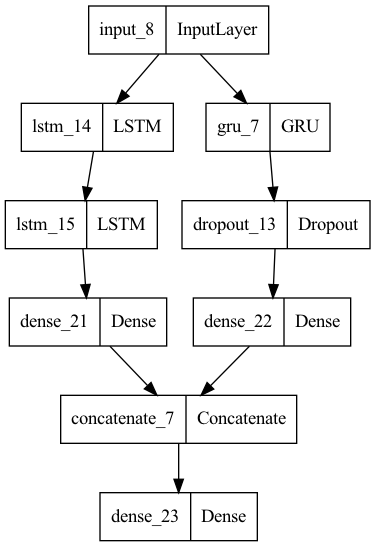

In [140]:
model.summary()
plot_model(model)

In [136]:
model.compile(optimizer='adam' , loss = 'mse')
model.fit(btcTrainGenny, validation_data = btcValGenny , epochs =100 , verbose = 1 )

Epoch 1/100
  347/27416 [..............................] - ETA: 6:01 - loss: 0.0050

KeyboardInterrupt: 

<Strong> LSTM Model : No. Of Neurons in Dense Layer ? </Strong>

<Strong> Weights stay the same for each timeseries. </Strong>